In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My\ Drive/Classroom/Spring2020-Deep\ Learning/Assignments/Assignment5

/content/drive/My Drive/Classroom/Spring2020-Deep Learning/Assignments/Assignment5


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import copy
from collections import OrderedDict
from sklearn.metrics import confusion_matrix

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [0]:
phases = ['train', 'validation', 'test']

In [0]:
data_dir = 'Assignment 5 Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in phases}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in phases}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

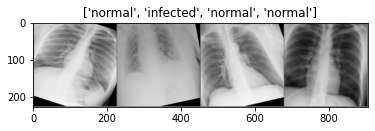

In [56]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss = []
    validation_loss = []
    for epoch in range(num_epochs):

        for phase in ['train', 'validation']:

            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_corrects = 0

            progress_bar = tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]))

            for i, data in progress_bar:

                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if(phase == 'train'):
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicted == labels.data)
                
                progress_bar.set_description(f'{phase} Epoch: {epoch}')
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] * 100

            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model)

    plt.plot(train_loss)
    plt.plot(validation_loss)
    plt.legend(["Train Loss", "Validation Loss"])
    plt.show()

    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
def accuracy(model, phase):

    correct = 0
    total = 0
    num_classes = len(class_names)

    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for data in dataloaders[phase]:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    print(f'{phase} Confusion Matrix = {confusion_matrix}')
    print(f'Accuracy of the network on {len(dataloaders[phase].dataset)} {phase} images: {(100 * correct / total)}')

In [0]:
def class_accuracy(model, phase):
    
    num_classes = len(class_names)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    with torch.no_grad():
        for data in dataloaders[phase]:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(num_classes):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [0]:
model_resnet = models.resnet18(pretrained=True)
roll_number = 13

for param in model_resnet.parameters():
    param.requires_grad = False

in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(OrderedDict([
                                            ('fc1', nn.Linear(in_features, roll_number * 10 + 100)),
                                            ('relu', nn.ReLU()),
                                            ('fc2', nn.Linear(roll_number * 10 + 100, 2))
]))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train Loss: 0.4833 Acc: 77.4167



validation Loss: 0.3873 Acc: 83.7333




train Loss: 0.4570 Acc: 79.1000



validation Loss: 0.3758 Acc: 84.2667




train Loss: 0.4438 Acc: 80.2833



validation Loss: 0.3783 Acc: 83.7333




train Loss: 0.4356 Acc: 79.9000



validation Loss: 0.3636 Acc: 85.7333




train Loss: 0.4327 Acc: 80.2667



validation Loss: 0.3480 Acc: 85.2000




train Loss: 0.4315 Acc: 80.3500



validation Loss: 0.3991 Acc: 84.7333




train Loss: 0.4274 Acc: 80.5000



validation Loss: 0.3456 Acc: 85.9333




train Loss: 0.4160 Acc: 80.9333



validation Loss: 0.3476 Acc: 85.6667




train Loss: 0.4110 Acc: 82.1083



validation Loss: 0.3830 Acc: 84.5333




train Loss: 0.4120 Acc: 81.3333



validation Loss: 0.3511 Acc: 85.7333

Training complete in 57m 45s
Best val Acc: 85.933333


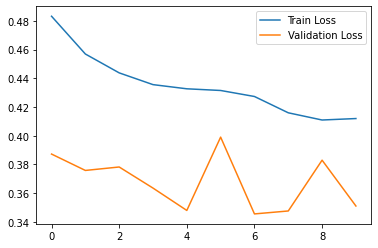

In [61]:
model_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

In [62]:
for phase in phases:
    accuracy(model_resnet, phase)

train Confusion Matrix = tensor([[3671., 1248.],
        [ 454., 6627.]])
Accuracy of the network on 12000 train images: 85.81666666666666
validation Confusion Matrix = tensor([[479., 136.],
        [ 75., 810.]])
Accuracy of the network on 1500 validation images: 85.93333333333334
test Confusion Matrix = tensor([[535.,  80.],
        [ 52., 833.]])
Accuracy of the network on 1500 test images: 91.2


In [0]:
torch.save(model_resnet.state_dict(), 'res18_FC_Only.pth')

In [64]:
model_vgg = models.vgg16(pretrained=True)
roll_number = 13

for param in model_vgg.features.parameters():
    param.require_grad = False

in_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1]
features.extend([nn.Linear(in_features, roll_number * 10 + 100)])
features.extend([nn.ReLU()])
features.extend([nn.Linear(roll_number * 10 + 100, 2)])
model_vgg.classifier = nn.Sequential(*features)

model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



train Loss: 0.3556 Acc: 85.4167



validation Loss: 0.2547 Acc: 90.6667




train Loss: 0.2840 Acc: 88.6917



validation Loss: 0.2877 Acc: 89.5333




train Loss: 0.2598 Acc: 90.2000



validation Loss: 0.2166 Acc: 91.2667




train Loss: 0.2506 Acc: 90.3083



validation Loss: 0.2057 Acc: 92.2667




train Loss: 0.2408 Acc: 90.5917



validation Loss: 0.1983 Acc: 92.6000




train Loss: 0.2346 Acc: 91.0833



validation Loss: 0.2178 Acc: 91.7333




train Loss: 0.2233 Acc: 91.2667



validation Loss: 0.2229 Acc: 91.8667




train Loss: 0.1850 Acc: 92.9250



validation Loss: 0.2012 Acc: 91.8667




train Loss: 0.1811 Acc: 92.9750



validation Loss: 0.1993 Acc: 92.0667




train Loss: 0.1775 Acc: 93.1667



validation Loss: 0.1862 Acc: 92.5333

Training complete in 47m 54s
Best val Acc: 92.600000


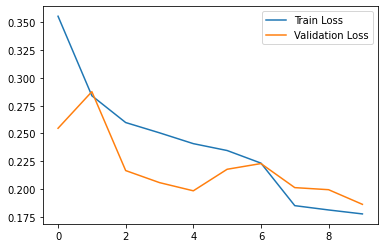

In [65]:
model_vgg = train_model(model_vgg, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

In [66]:
for phase in phases:
    accuracy(model_vgg, phase)

train Confusion Matrix = tensor([[4387.,  532.],
        [ 420., 6661.]])
Accuracy of the network on 12000 train images: 92.06666666666666
validation Confusion Matrix = tensor([[550.,  65.],
        [ 46., 839.]])
Accuracy of the network on 1500 validation images: 92.6
test Confusion Matrix = tensor([[585.,  30.],
        [  5., 880.]])
Accuracy of the network on 1500 test images: 97.66666666666667


In [0]:
torch.save(model_resnet.state_dict(), 'vgg16_FC_Only.pth')

# Task 2

Only training FC layer of ResNet


train Loss: 0.6454 Acc: 74.0000



validation Loss: 0.4595 Acc: 83.6000




train Loss: 0.6100 Acc: 75.2583



validation Loss: 0.4179 Acc: 84.0667




train Loss: 0.5899 Acc: 75.5500



validation Loss: 0.3926 Acc: 84.8000




train Loss: 0.6151 Acc: 75.6333



validation Loss: 0.3999 Acc: 85.2000




train Loss: 0.5871 Acc: 76.4000



validation Loss: 0.4643 Acc: 82.4667




train Loss: 0.5854 Acc: 75.8917



validation Loss: 0.3960 Acc: 85.4000




train Loss: 0.5837 Acc: 76.2750



validation Loss: 0.5350 Acc: 81.6000




train Loss: 0.4611 Acc: 79.6917



validation Loss: 0.3793 Acc: 85.0667




train Loss: 0.4621 Acc: 78.9750



validation Loss: 0.3669 Acc: 85.4667




train Loss: 0.4425 Acc: 80.4083



validation Loss: 0.3664 Acc: 85.9333

Training complete in 41m 56s
Best val Acc: 85.933333


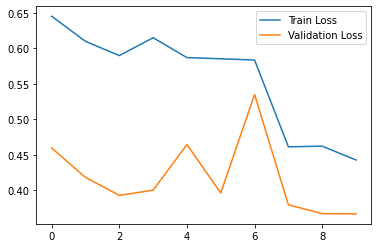

train Confusion Matrix = tensor([[3695., 1224.],
        [ 542., 6539.]])
Accuracy of the network on 12000 train images: 85.28333333333333
validation Confusion Matrix = tensor([[503., 112.],
        [ 99., 786.]])
Accuracy of the network on 1500 validation images: 85.93333333333334
test Confusion Matrix = tensor([[547.,  68.],
        [ 81., 804.]])
Accuracy of the network on 1500 test images: 90.06666666666666


In [68]:
model_resnet = models.resnet18(pretrained=True)
in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, 2)

for param in model_resnet.parameters():
    param.requires_grad = False

for param in model_resnet.fc.parameters():
    param.requires_grad = True

model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
for phase in phases:
    accuracy(model_resnet, phase)
torch.save(model_resnet.state_dict(), 'res18_only_FC.pth')

Training only last 4 layers of ResNet

In [0]:
model_resnet = models.resnet18(pretrained=True)
in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, 2)

children = 0
for child in model_resnet.children():
    children += 1
    if children < 7:
        for param in child.parameters():
            param.requires_grad = False

model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
for phase in phases:
    accuracy(model_resnet, phase)
torch.save(model_resnet.state_dict(), 'res18_Last_4.pth')

Training the entire ResNet end to end

In [0]:
model_resnet = models.resnet18(pretrained=True)
in_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_features, 2)
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
for phase in phases:
    accuracy(model_resnet, phase)
torch.save(model_resnet.state_dict(), 'res18_entire.pth')

Training only last FC layer of VGG

In [0]:
model_vgg = models.vgg18(pretrained=True)

for param in model_vgg.parameters():
    para.requires_grad = False

for param in model_vgg.classifier[6].parameters():
    para.requires_grad = True

in_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1]
features.extend([nn.Linear(in_features, roll_number * 10 + 100)])
features.extend([nn.ReLU()])
features.extend([nn.Linear(roll_number * 10 + 100, 2)])
model_vgg.classifier = nn.Sequential(*features)

model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_vgg = train_model(model_vgg, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
for phase in phases:
    accuracy(model_vgg, phase)
torch.save(model_vgg.state_dict(), 'vgg16_only_FC.pth')

Training few convolutional and FC layers of VGG

In [0]:
model_vgg = models.vgg18(pretrained=True)

children = 0
for child in model_vgg.features.children():
    children += 1
    if children < 24:
        for param in child.parameters():
            param.requires_grad = False

in_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1]
features.extend([nn.Linear(in_features, roll_number * 10 + 100)])
features.extend([nn.ReLU()])
features.extend([nn.Linear(roll_number * 10 + 100, 2)])
model_vgg.classifier = nn.Sequential(*features)

model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_vgg = train_model(model_vgg, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
for phase in phases:
    accuracy(model_vgg, phase)
torch.save(model_vgg.state_dict(), 'vgg16_Last_7.pth')

Training entire VGG end to end

In [0]:
model_vgg = models.vgg18(pretrained=True)

in_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1]
features.extend([nn.Linear(in_features, roll_number * 10 + 100)])
features.extend([nn.ReLU()])
features.extend([nn.Linear(roll_number * 10 + 100, 2)])
model_vgg.classifier = nn.Sequential(*features)

model_vgg = model_vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_vgg = train_model(model_vgg, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
for phase in phases:
    accuracy(model_vgg, phase)
torch.save(model_vgg.state_dict(), 'vgg16_entire.pth')